**[Breast Cancer Coimbra Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Coimbra#)** 


9 features + classification(1=Healthy controls, 2=Patients)

116 instances = 52(label=1) + 64(label=2)


**Features**

BMI: $weights_{kg}\div(height_{m})^{2}$

Glucose: is a type of sugar. It is your body's main source of energy

Inslin: A hormone called insulin helps move glucose from your bloodstream into your cells. 

HOMA(Homeostatic model assessment): is a method for assessing β-cell function and insulin resistance

Leptin: is a hormone that helps regulate appetite by signaling hunger satisfaction.

Adiponectin: is a hormone that is released from fat cells and will help to control the inflammation of tissue.It is used to diagnose metabolic disorders such as Type 2 diabetes.

Resistin: increases the production of LDL in human liver cells and also degrades LDL receptors in the liver. As a result, the liver is less able to clear 'bad' cholesterol from the body.

MCP-1(Monocyte chemoattractant protein-1): is one of the key chemokines that regulate migration and infiltration of monocytes/macrophages


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans


from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def unison_shuffle(data):
  inx = np.random.permutation(data.shape[0])
  return data.iloc[inx]

def data_loading(path):
    data = pd.read_csv(path, sep=',')
    return data

def split_data(X, y):
    # train_X= X.iloc[:X.shape[0]-20]
    # train_y= y.iloc[:y.shape[0]-20]

    # valid_X= X.iloc[X.shape[0]-40:X.shape[0]-20]
    # valid_y= y.iloc[y.shape[0]-40:y.shape[0]-20]

    test_X= X.iloc[X.shape[0]-20:]
    test_y= y.iloc[y.shape[0]-20:]

    tv_X= X.iloc[:X.shape[0]-20]
    tv_y= y.iloc[:y.shape[0]-20]

    # print(train_X.shape, valid_X.shape, test_X.shape)
    # return train_X, train_y, valid_X, valid_y, test_X, test_y
    print(tv_X.shape, test_X.shape)
    return tv_X, tv_y, test_X, test_y
  
def plot_index_feature(data, target):
    features= list(data.columns.values)
    colors = ['r', 'b', 'g']
    for feature in features:
        if feature == 'index':
            continue
        for gp in list(set(data[target])):
            plt.scatter( data[data[target]==gp]['index'], data[data[target]==gp][feature], color = colors[gp], label = gp)
        plt.xlabel('Index')
        plt.ylabel(feature)
        plt.legend()   
        plt.show()

        
def plot_feature_by_feature(data, target):
    features= list(data.columns.values)
    colors = ['r', 'b', 'g']
    two_features=[[features[i], features[j]] for i in range(1, len(features))
              for j in range(len(features)) if i < j]
    
    for f1,f2 in two_features:
        for gp in list(set(data[target])):
            plt.scatter( data[data[target]==gp][f1], data[data[target]==gp][f2], color = colors[gp], label = gp)
        plt.xlabel(f1)
        plt.ylabel(f2)
        plt.legend()   
        plt.show()

In [3]:
def logistic_regression(X, y, k):
    scores= [[],[]]
    kf = KFold(n_splits=k, random_state=True, shuffle=True)
    
    for train, valid in kf.split(X, y):
        model = make_pipeline(StandardScaler(), LogisticRegression(random_state = 0))
        model.fit(X.iloc[train],y.iloc[train])
        y_pred = model.predict(X.iloc[valid])
        scores[0].append(model.score(X.iloc[train], y.iloc[train]))
        scores[1].append(model.score(X.iloc[valid], y.iloc[valid]))
        
    print('Accuracy of logistic regression classifier on train set: %.3f (%.3f), on valid set: %.3f (%.3f)' 
          % (np.mean(scores[0]), np.std(scores[0]), np.mean(scores[1]), np.std(scores[1])))


In [4]:
def SVM(X, y, kernel, k, c, gamma):
    scores=[[],[]]
    kf = KFold(n_splits=k, random_state=True, shuffle=True)
    
    #model = SVC(kernel=kernel, random_state= True, C=1, gamma=1)
    for train, test in kf.split(X, y):
        model = make_pipeline(StandardScaler(), SVC(kernel=kernel, random_state= None, C=c, gamma=gamma))
        model.fit(X.iloc[train],y.iloc[train])
        scores[0].append(model.score(X.iloc[train], y.iloc[train]))
        scores[1].append(model.score(X.iloc[test], y.iloc[test]))
       
    print('Accuracy of SVM with %s kernel classifier on train set: %.3f (%.3f), on valid set: %.3f (%.3f)' 
          % (kernel, np.mean(scores[0]), np.std(scores[0]), np.mean(scores[1]), np.std(scores[1])))
    


In [5]:
def decision_tree(X, y, k, max_depth):
    scores = [[], []]
    kf = KFold(n_splits=k, random_state=True, shuffle=True)
    for train, valid in kf.split(X, y):
        model = DecisionTreeClassifier(random_state=0, ccp_alpha=0.033)
        sc = StandardScaler()
        sc.fit(X.iloc[ train ])
        X_train = X.iloc[train]
        X_valid = X.iloc[valid]
        model.fit(X_train,y.iloc[train])
        # plot_tree(model, filled=True)
        # plt.show()
        scores[0].append(model.score(X_train, y.iloc[train]))
        scores[1].append(model.score(X_valid, y.iloc[valid]))
    print('Accuracy of Decision Tree classifier on train set: %.3f (%.3f), on valid set: %.3f (%.3f)' 
          % (np.mean(scores[0]), np.std(scores[0]), np.mean(scores[1]), np.std(scores[1])))


In [6]:
def k_means(X, y, k, ncluster):
    scores= []
    model= KMeans(n_clusters=ncluster)
    
    model.fit(X)
    y_kmeans = model.predict(X)

    reduced_data = PCA(n_components=2).fit_transform(X)
    results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
    sns.scatterplot(x="pca1", y="pca2", hue=y_kmeans, data=results)
    plt.title('K-means Clustering with 2 dimensions')
    plt.show()
    return model
                

In [7]:
path="/content/drive/MyDrive/Datasets/breast_cancer.csv"
data = data_loading(path)
data = unison_shuffle(data)
category = 'Classification'
data = data.reset_index()
data.shape

(116, 11)

In [8]:
data[category].value_counts()

2    64
1    52
Name: Classification, dtype: int64

In [9]:
data.head()

,index,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,17,61,32.038959,85,18.077,3.790144,30.7729,7.780255,13.68392,444.395,1
1,97,40,27.636054,103,2.432,0.617890,14.3224,6.783870,26.01360,293.123,2
2,81,81,31.640368,100,9.669,2.385020,38.8066,10.636525,29.55830,426.175,2
3,59,62,22.656250,92,3.482,0.790182,9.8648,11.236235,10.69548,703.973,2
4,100,74,28.650138,88,3.012,0.653805,31.1233,7.652220,18.35574,572.401,2


In [10]:
X = data.iloc[:,1:-1]
y = data.iloc[:, -1]

In [ ]:
plot_index_feature(data, category)

In [ ]:
plot_feature_by_feature(data, category)

***Results***

*It seems people with higher Glucose, Insulin, Homa and Resistin are more at risk of becoming patients*

*also most of patients are between 40 and 80 years old*

Accuracy of logistic regression classifier on train set: 0.780 (0.021), on valid set: 0.786 (0.099)
Accuracy of SVM with linear kernel classifier on train set: 0.791 (0.018), on valid set: 0.741 (0.073)
Accuracy of SVM with rbf kernel classifier on train set: 0.866 (0.018), on valid set: 0.750 (0.087)
Accuracy of Decision Tree classifier on train set: 0.890 (0.049), on valid set: 0.733 (0.037)


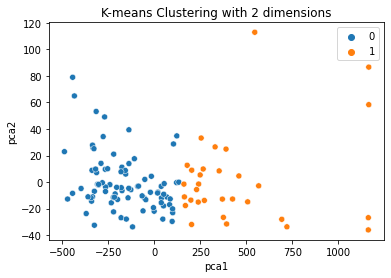

In [13]:
logistic_regression(X, y, 5)
SVM(X, y, 'linear', 5, 1, 1)
SVM(X, y, 'rbf', 5, 0.9, 0.1)
decision_tree(X, y, 5, 4)
model = k_means(X, y, 5, 2)

Moniba Ravan